<a href="https://colab.research.google.com/github/VFdo/FYRP/blob/main/model_testing/CodeReviewer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments

tokenizer = AutoTokenizer.from_pretrained("microsoft/codereviewer")
model = AutoModelForSeq2SeqLM.from_pretrained("microsoft/codereviewer")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
# Example code snippets
code_snippets = [
    "def add(a, b): return a + b",
    "def divide(a, b): return a / b if b != 0 else 'Error: Division by zero'",
    "def divide2(a, b): return a / b",
    # "final String decodedString = URLDecoder.decode(s, \"ISO-8859-1\");"
    "if (width > 0) {\n    ensureCapacity(size + width);\n    String str = (obj == null ? getNullText() : obj.toString());\n[ADD]    (str == null) {\n[ADD]        str = "";\n[ADD]    }\n    int strLen = str.length();"
]

# reviews = [
#     "No issues detected.",
#     "Potential division by zero error.",
#     "No issues detected."
# ]

# Tokenize the input
inputs = tokenizer(code_snippets, return_tensors="pt", padding=True, truncation=True)
# labels = tokenizer(reviews, return_tensors="pt", padding=True, truncation=True)



## Fine-Tune

In [19]:
import torch
from torch.utils.data import Dataset

class CodeReviewDataset(Dataset):
    def __init__(self, code_snippets, reviews, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.data = []
        for code, review in zip(code_snippets, reviews):
            inputs = self.tokenizer.encode_plus(
                code,
                max_length=max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            targets = self.tokenizer.encode_plus(
                review,
                max_length=max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            self.data.append({
                "input_ids": inputs["input_ids"].squeeze(),
                "attention_mask": inputs["attention_mask"].squeeze(),
                "labels": targets["input_ids"].squeeze()
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = CodeReviewDataset(code_snippets, reviews, tokenizer)


In [20]:
# Fine-tune the model (optional)
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    logging_dir="./logs",
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset, # Use the dataset variable here
    # eval_dataset=labels, # You can optionally provide an evaluation dataset here
)

trainer.train()

Step,Training Loss


TrainOutput(global_step=6, training_loss=9.144334157307943, metrics={'train_runtime': 194.8915, 'train_samples_per_second': 0.046, 'train_steps_per_second': 0.031, 'total_flos': 5480621015040.0, 'train_loss': 9.144334157307943, 'epoch': 3.0})

# Output

In [12]:
# Run inference to detect bugs
outputs = model.generate(**inputs)

# Decode the output
decoded_outputs = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# Print the results
for i, code in enumerate(code_snippets):
    print(f"Original Code:\n{code}\nReview:\n{decoded_outputs[i]}\n")

Original Code:
def add(a, b): return a + b
Review:
<e0>def add

Original Code:
def divide(a, b): return a / b if b != 0 else 'Error: Division by zero'
Review:
<e0>return a

Original Code:
def divide2(a, b): return a / b
Review:
<e0>def

Original Code:
if (width > 0) {
    ensureCapacity(size + width);
    String str = (obj == null ? getNullText() : obj.toString());
[ADD]    (str == null) {
[ADD]        str = ;
[ADD]    }
    int strLen = str.length();
Review:
<msg>This is not needed.



#Pipeline

In [18]:
from transformers import pipeline

pipe = pipeline("text2text-generation", model="microsoft/codereviewer")

code = """
Vector3D v1D = line.intersection(subLine.line);
[ADD]if (v1D == null) {
[ADD]    return null;
[ADD]}
Location loc1 = remainingRegion.checkPoint(line.toSubSpace(v1D));
"""

pipe(code, max_length=512, num_return_sequences=1)[0]["generated_text"]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


'<msg>This is a bit of a nitpick, but I think it would be better to have a blank line between the `if` and the `(`'

In [23]:
from transformers import pipeline

pipe = pipeline("text2text-generation", model="microsoft/codereviewer")

code = """
public byte[] getByteCode() {
        setPositions();
        ByteArrayOutputStream b = new ByteArrayOutputStream();
        DataOutputStream out = new DataOutputStream(b);
        try {
            for (InstructionHandle ih = start; ih != null; ih = ih.getNext()) {
                Instruction i = ih.getInstruction();
                i.dump(out);
            }
[ADD]            out.flush();
        } catch (IOException e) {
            System.err.println(e);
            return new byte[0];
"""

pipe(code, max_length=512, num_return_sequences=1)[0]["generated_text"]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


'<msg>This is a good change, but I think it would be better to use a try-with-resources block to close the stream.'

In [27]:
from transformers import pipeline

pipe = pipeline("text2text-generation", model="microsoft/codereviewer")

code = """
try {
    return typedArray.getString(0);
}
[ADD]catch (Exception ignore) {
[ADD]    return null;
[ADD]}
finally {
    typedArray.recycle();
}
"""

pipe(code, max_length=512, num_return_sequences=1)[0]["generated_text"]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


'<msg>This is not needed.'

In [79]:
from transformers import pipeline

pipe = pipeline("text2text-generation", model="microsoft/codereviewer")

code = """
[MSG]
[DEL]if (ptString.indexOf('(') > 0) {
[DEL]    this.pt = Long.parseLong(ptString.substring(0, ptString.indexOf('(')));
[DEL]} else {
[DEL]    this.pt = Long.parseLong(ptString);
[DEL]}
[ADD]try {
[ADD]    if (ptString.indexOf('(') > 0) {
[ADD]        this.pt = Long.parseLong(ptString.substring(0, ptString.indexOf('(')));
[ADD]    } else {
[ADD]        this.pt = Long.parseLong(ptString);
[ADD]    }
[ADD]} catch (NumberFormatException e) {
[ADD]    throw new NumberFormatException(String.format("Input string [%s] is not a parsable long", ptString));
[ADD]}
"""
pipe(code)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'generated_text': '<msg>Please remove this extra line'}]

In [6]:
code = """
// compute the intersection on infinite line
Vector2D v2D = line1.intersection(line2);
[ADD]if (v2D == null) {
[ADD]    return null;
[ADD]}

// check location of point with respect to first sub-line
Location loc1 = getRemainingRegion().checkPoint(line1.toSubSpace(v2D));
"""

pipe(code, max_length=512)

[{'generated_text': '<msg>This is a bit of a nitpick, but I think it would be better to have a blank line between the two blocks.'}]

In [7]:
code = """
try {
    m_cipher.init(Cipher.ENCRYPT_MODE, m_key);
    byte[] encBytes = m_cipher.doFinal(clearText.getBytes("UTF8"));
    String encString = convertToHexString(encBytes);
    AlgorithmParameters ap = m_cipher.getParameters();
    m_cipher.init(Cipher.DECRYPT_MODE, m_key, ap);
    byte[] out = m_cipher.doFinal(data);
[DEL]    String retValue = new String(out);
[ADD]    String retValue = new String(out, "UTF8");
    return retValue;
"""

pipe(code, max_length=512)

[{'generated_text': '<msg>This is a bit of a nitpick, but I think it would be better to have a method that returns a String, and then call that method from the other methods.'}]

In [11]:
code = """
RSAPublicKey rsaPublicKey = (RSAPublicKey) publicKey;
RSAPrivateKeySpec spec = new RSAPrivateKeySpec(rsaPublicKey.getModulus(), rsaPublicKey.getPublicExponent());
Key fakePrivateKey = KeyFactory.getInstance("RSA").generatePrivate(spec);
[ADD]cipher = Cipher.getInstance("RSA");
cipher.init(Cipher.DECRYPT_MODE, fakePrivateKey);
"""

pipe(code, max_length=512)

[{'generated_text': '<msg>This is not needed.'}]

In [9]:
code = """
[DEL]cipher.init(Cipher.ENCRYPT_MODE, privateKey);
[ADD]try {
[ADD]    cipher.init(Cipher.ENCRYPT_MODE, privateKey);
[ADD]} catch (InvalidKeyException e) {
[ADD]    RSAPrivateKey rsaPrivateKey = (RSAPrivateKey) privateKey;
[ADD]    RSAPublicKeySpec publicKeySpec = new RSAPublicKeySpec(rsaPrivateKey.getModulus(), [ADD]rsaPrivateKey.getPrivateExponent());
[ADD]    Key publicKey = KeyFactory.getInstance("RSA").generatePublic(publicKeySpec);
[ADD]    cipher = Cipher.getInstance("RSA");
[ADD]    cipher.init(Cipher.ENCRYPT_MODE, publicKey);
[ADD]}
"""

pipe(code, max_length=512)

[{'generated_text': '<msg>This is a bit of a nitpick, but I think it would be better to have a blank line between the `try` and the `catch` block.'}]

## Add Classification Head

In [2]:
!pip install transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [1]:
import pandas as pd

# Assuming your dataset is in CSV format
df = pd.read_csv("/content/tune_data.csv")
df.head()


,code,label
0,if (width > 0) {\n ensureCapacity(size + wi...,0
1,if (width > 0) {\n ensureCapacity(size + wi...,0
2,// compute the intersection on infinite line\n...,0
3,// compute the intersection on infinite line\n...,0
4,"try {\n m_cipher.init(Cipher.ENCRYPT_MODE, ...",1


In [2]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)

In [21]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

def preprocess_function(examples):
    return tokenizer(examples['code'], truncation=True, padding='max_length')

tokenized_dataset = dataset.map(preprocess_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

In [22]:
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.4)


In [9]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# model = AutoModelForSequenceClassification.from_pretrained("microsoft/codereviewer")
tokenized_dataset = tokenized_dataset.map(lambda examples: {'labels': examples['label']}, batched=True)

model = AutoModelForSequenceClassification.from_pretrained("microsoft/codereviewer", num_labels=4) # Replace num_labels with the number of classes in your classification task

# model = AutoModelForSequenceClassification.from_pretrained("microsoft/codereviewer")

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at microsoft/codereviewer and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,  # Reduced batch size
    per_device_eval_batch_size=2,  # Reduced batch size
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)


In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,1.618875
2,No log,1.460195
3,No log,1.401098


TrainOutput(global_step=45, training_loss=1.415176476372613, metrics={'train_runtime': 48.6917, 'train_samples_per_second': 1.848, 'train_steps_per_second': 0.924, 'total_flos': 54970347479040.0, 'train_loss': 1.415176476372613, 'epoch': 3.0})

In [12]:
results = trainer.evaluate()
print(results)

{'eval_loss': 1.4010982513427734, 'eval_runtime': 1.96, 'eval_samples_per_second': 10.714, 'eval_steps_per_second': 5.612, 'epoch': 3.0}


In [13]:
model.save_pretrained("./fine_tuned_codereviewer")
tokenizer.save_pretrained("./fine_tuned_codereviewer")

('./fine_tuned_codereviewer/tokenizer_config.json',
 './fine_tuned_codereviewer/special_tokens_map.json',
 './fine_tuned_codereviewer/vocab.json',
 './fine_tuned_codereviewer/merges.txt',
 './fine_tuned_codereviewer/added_tokens.json',
 './fine_tuned_codereviewer/tokenizer.json')

In [56]:
from google.colab import files
!zip -r fine_tuned_codereviewer.zip ./fine_tuned_codereviewer
files.download("fine_tuned_codereviewer.zip")


  adding: fine_tuned_codereviewer/ (stored 0%)
  adding: fine_tuned_codereviewer/model.safetensors (deflated 7%)
  adding: fine_tuned_codereviewer/special_tokens_map.json (deflated 81%)
  adding: fine_tuned_codereviewer/merges.txt (deflated 54%)
  adding: fine_tuned_codereviewer/vocab.json (deflated 59%)
  adding: fine_tuned_codereviewer/config.json (deflated 65%)
  adding: fine_tuned_codereviewer/tokenizer_config.json (deflated 95%)
  adding: fine_tuned_codereviewer/added_tokens.json (deflated 76%)
  adding: fine_tuned_codereviewer/tokenizer.json (deflated 72%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Model Performance for Classification

In [14]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_codereviewer")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_codereviewer")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
# Example Java code snippet
# code_snippet = "try { FileInputStream fis = new FileInputStream(fileName); } catch (IOException e) { e.printStackTrace(); }"
code = """
RSAPublicKey rsaPublicKey = (RSAPublicKey) publicKey;
RSAPrivateKeySpec spec = new RSAPrivateKeySpec(rsaPublicKey.getModulus(), rsaPublicKey.getPublicExponent());
Key fakePrivateKey = KeyFactory.getInstance("RSA").generatePrivate(spec);
[ADD]cipher = Cipher.getInstance("RSA");
cipher.init(Cipher.DECRYPT_MODE, fakePrivateKey);
"""
# missing/call

# # Tokenize the input text
# inputs = tokenizer.encode(code_snippet, return_tensors="pt")

# # Generate output from the model
# outputs = model.generate(inputs, max_length=150, num_beams=5, early_stopping=True)

# # Decode the generated text
# generated_review = tokenizer.decode(outputs[0], skip_special_tokens=True)

# print("Generated Review:")
# print(generated_review)

# Tokenize the input
inputs = tokenizer(code, return_tensors="pt", truncation=True, padding='max_length')

# Run the model on the input
outputs = model(**inputs)

# Get the prediction
predictions = outputs.logits.argmax(-1)
label_map = {0: "missing/condition/null_check", 1: "missing/call", 2: "missing/exception_handling", 3: "missing/condition/value_or_state"}  # Adjust according to your label mapping
predicted_label = label_map[predictions.item()]

print(f"Prediction: {predicted_label}")

Prediction: missing/condition/value_or_state


# Evaluation

In [12]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_codereviewer")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_codereviewer")

model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32216, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32216, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_feat

In [17]:
import torch

m1 = df[df.columns[0]]
test_data = m1.tolist()

# Initialize a list to store predicted labels
predicted_labels = []

# Iterate over each code snippet in the test data
for code in test_data:
    # Tokenize the input text
    inputs = tokenizer.encode(code, return_tensors="pt")

    # Get the model's output logits
    with torch.no_grad():
        outputs = model(inputs)

    # The model's output is logits, so you can use argmax to get the predicted label
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Append the predicted label to the list
    predicted_labels.append(predicted_label)

# Print out the predicted labels
print("Predicted Labels:", predicted_labels)


Predicted Labels: [0, 0, 3, 3, 3, 3, 2, 2, 1, 3, 3, 2, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 0, 2, 1, 0, 1, 3, 2, 3, 3, 3, 0, 2, 1, 3, 1, 2, 0, 2, 1, 0, 2, 1, 3, 3, 1, 2, 1, 3, 3]


In [18]:
m2 = df[df.columns[1]]
true_labels = m2.tolist()
print(true_labels)

[0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 3, 2, 1, 2, 2, 3, 2, 0, 3, 3, 2, 1, 1, 2, 0, 0, 1, 1, 0, 0, 1, 0, 3, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]


[0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 3, 2, 1, 2, 2, 3, 2, 0, 3, 3, 2, 1, 1, 2, 0, 0, 1, 1, 0, 0, 1, 0, 3, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]
[0, 0, 3, 3, 3, 3, 2, 2, 1, 3, 3, 2, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 0, 2, 1, 0, 1, 3, 2, 3, 3, 3, 0, 2, 1, 3, 1, 2, 0, 2, 1, 0, 2, 1, 3, 3, 1, 2, 1, 3, 3]
Accuracy: 0.5098
Precision: 0.5155
Recall: 0.5160
F1 Score: 0.4945
Confusion Matrix:


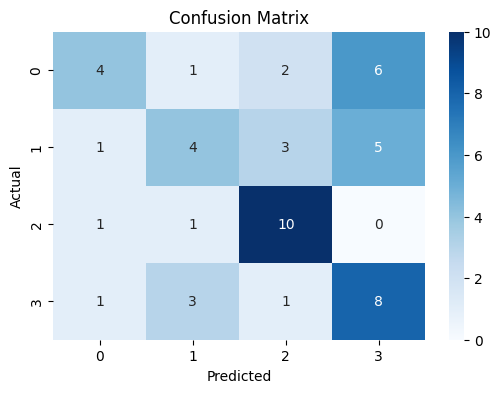

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
# true_labels = [1, 0, 1, 0, 1]  # Replace with actual true labels
# predicted_labels = [1, 0, 0, 0, 1]  # Replace with model's predicted labels
print(true_labels)
print(predicted_labels)

# Run the evaluation
accuracy = accuracy_score(true_labels, predicted_labels)
# Set average to 'macro' for multiclass problems
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
# Step 11: Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


[0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 3, 2, 1, 2, 2, 3, 2, 0, 3, 3, 2, 1, 1, 2, 0, 0, 1, 1, 0, 0, 1, 0, 3, 0, 1, 0, 1, 1, 0, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3]
[0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 2, 1, 2, 2, 3, 2, 3, 3, 3, 2, 1, 1, 2, 1, 3, 3, 1, 3, 1, 1, 0, 3, 3, 1, 0, 1, 1, 0, 2, 2, 2, 2, 3, 3, 3, 0, 3, 1, 3, 3]
Accuracy: 0.7843
Precision: 0.8036
Recall: 0.7885
F1 Score: 0.7823
Confusion Matrix:


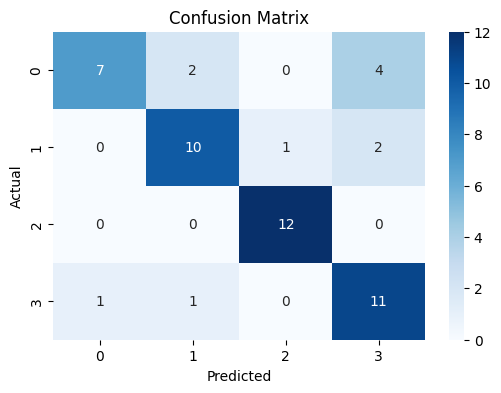

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Example data
true_labels = [0,0,0,0,1,1,2,2,1,1,3,2,1,2,2,3,2,0,3,3,2,1,1,2,0,0,1,1,0,0,1,0,3,0,1,0,1,1,0,2,2,2,2,3,3,3,3,3,3,3,3]  # Replace with actual true labels
predicted_labels = [0,0,0,0,1,1,2,2,2,3,3,2,1,2,2,3,2,3,3,3,2,1,1,2,1,3,3,1,3,1,1,0,3,3,1,0,1,1,0,2,2,2,2,3,3,3,0,3,1,3,3]  # Replace with model's predicted labels
print(true_labels)
print(predicted_labels)

# Run the evaluation
accuracy = accuracy_score(true_labels, predicted_labels)
# Set average to 'macro' for multiclass problems
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
# Step 11: Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()